# Predicting outcomes for patients with and without thrombolysis

In [1]:
fit_new_models = False
combine_stroke_teams = False # Refit model if this is changed

In [2]:
# Import packages and data, and fit models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

# Fields for model
X_fields = [
    'prior_disability',
    'stroke_severity',
    'stroke_team',
    'onset_to_thrombolysis',
    'age',
    'precise_onset_known',
    'any_afib_diagnosis'
    ]
# Load data and get X and y
data = pd.read_csv('./data/data_for_ml/complete_ml_data.csv', low_memory=False)
# Get min and max years
min_year = data['year'].min()
max_year = data['year'].max()
# Limit to infarction = 1
mask = data['infarction'] == 1
data = data[mask]
number_patients_thrombolysed = np.sum(data['onset_to_thrombolysis'] > 0)
# Remove patients who received thrombectomy
mask = data['thrombectomy'] == 0
data = data[mask]
# Combine stroke teams
if combine_stroke_teams:
    data['stroke_team'] = 'All'
# Reindex
data = data.reset_index(drop=True)
stroke_teams = list(data['stroke_team'].unique())
stroke_teams.sort()
# Restrict to fields to use
fields_to_use = X_fields + ['discharge_disability']
data = data[fields_to_use]
# One hot encode stroke teams using OneHotEncoder with stroke_teams as categories
enc = OneHotEncoder(categories=[stroke_teams])
enc.fit(data[['stroke_team']])
one_hot = enc.transform(data[['stroke_team']]).toarray()
one_hot = pd.DataFrame(one_hot, columns=stroke_teams)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(columns=['stroke_team'])

if fit_new_models:
    # Fit models
    replicates = 100
    model_full = []

    for i in range(replicates):
        # Sample data
        sample = data.sample(frac=1.0, random_state=42+i, replace=True)
        X = sample.drop(columns=['discharge_disability'])
        y = sample['discharge_disability']
        # Fit full model
        model = XGBClassifier(random_state=42+i)
        model.fit(X, y)
        model_full.append(model)
    
    # Pickle models
    pickle.dump(model_full, open('./pickled_models/outcome_models.pkl', 'wb'))

else:
    # Load models
    model_full = pickle.load(open('./pickled_models/outcome_models.pkl', 'rb'))
    replicates = len(model_full)

# Function to analyse and plot patient
def analyse_patient(patient):
    # Get predictions for patient
    untreated_dist = []
    treated_dist = []
    untreated_less_2 = []
    treated_less_2 = []
    untreated_more_4 = []
    treated_more_4 = []
    untreated_weighted_mrs = []
    treated_weighted_mrs = []
    improvement = []

    # Set up patient for predictions
    patient = pd.DataFrame(patient, index=[0])
    one_hot_encoded = enc.transform(patient[['stroke_team']]).toarray()
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=stroke_teams, index=[0])
    patient_treated = pd.concat([patient, one_hot_encoded_df], axis=1)
    patient_treated.drop('stroke_team', axis=1, inplace=True)
    patient_untreated = patient_treated.copy()
    patient_untreated['onset_to_thrombolysis'] = -10

    for i in range(replicates):
        # Get untreated and treated distributions
        untreated = model_full[i].predict_proba(pd.DataFrame(patient_untreated, index=[0]))[0]
        treated = model_full[i].predict_proba(pd.DataFrame(patient_treated, index=[0]))[0]
        untreated_dist.append(untreated)
        treated_dist.append(treated)
        # Get weighted average of mRS scores
        weighted_untreated = np.sum(untreated * np.arange(7))
        weighted_treated = np.sum(treated * np.arange(7))
        untreated_weighted_mrs.append(weighted_untreated)
        treated_weighted_mrs.append(weighted_treated)
        improvement.append(0-(weighted_treated - weighted_untreated))
        # Get untreated and treated distributions for mRS <3
        untreated_less_2.append(np.sum(untreated[:3]))
        treated_less_2.append(np.sum(treated[:3]))
        # Get untreated and treated distributions for mRS >4
        untreated_more_4.append(np.sum(untreated[5:]))
        treated_more_4.append(np.sum(treated[5:]))

    #### PLOT ####

    # Convert patient to dataframe
    patient = pd.DataFrame(patient, index=[0])


    # Draw a dotted histogram of the untreated and treated distributions
    fig = plt.figure(figsize=(15, 6))

    # Add patient dictionary as a text box
    ax = fig.add_subplot(131)
    patient_dict = patient.iloc[0].to_dict()
    patient_text = 'PATIENT CHARACTERISTICS\n\n'

    patient_text = patient_text + (
        '\n'.join([f'{k}: {v}' for k, v in patient_dict.items()]))

    patient_text = patient_text + f'\n\n\nLIKELY OUTCOME\n'

    v = np.mean(untreated_weighted_mrs)
    patient_text = patient_text + f'\nUntreated weighted mRS = {v:0.1f}'
    v = np.mean(treated_weighted_mrs)
    patient_text = patient_text + f'\nTreated weighted mRS = {v:0.1f}'
    v = np.mean(improvement)
    patient_text = patient_text + f'\nmRS improvement = {v:0.2f}'

    v = np.mean(untreated_less_2)
    patient_text = patient_text + f'\n\nUntreated proportion mRS 0-2 = {v:0.2f}'
    v = np.mean(treated_less_2)
    patient_text = patient_text + f'\nTreated proportion mRS 0-2 = {v:0.2f}'
    v = (np.mean(treated_less_2) - np.mean(untreated_less_2))
    patient_text = patient_text + f'\nChange in proportion mRS 0-2 = {v:0.2f}'

    v = np.mean(untreated_more_4)
    patient_text = patient_text + f'\n\nUntreated proportion mRS 5-6 = {v:0.2f}'
    v = np.mean(treated_more_4)
    patient_text = patient_text + f'\nTreated proportion mRS 5-6 = {v:0.2f}'
    v = (np.mean(treated_more_4) - np.mean(untreated_more_4))
    patient_text = patient_text + f'\nChange in proportion mRS 5-6 = {v:0.2f}'
    patient_text = patient_text + f'\n\n{replicates} bootstrapped models built from {len(data):,} patients.'
    patient_text = patient_text + f'\n{number_patients_thrombolysed:,} patients thrombolysed.'
    patient_text = patient_text + f'\nModel built from data between {min_year} and {max_year}.'


    ax.text(0.10, 0.97, patient_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top')

    # Remove all axes
    ax.axis('off')

    # Plot outcomes
    ax = fig.add_subplot(132)
    x = np.arange(7)
    untreated_dist_mean = np.mean(untreated_dist, axis=0)
    ax.bar(x-0.2, untreated_dist_mean, 
        color='red', label=f'Untreated', linewidth=1, linestyle='--', width=0.4, alpha=0.7)
    treated_dist_mean = np.mean(treated_dist, axis=0)
    ax.bar(x+0.2, treated_dist_mean,
        color='blue', label=f'Treated', linewidth=1, linestyle='--', width=0.4, alpha=0.7)
    
    # Calculate error as 95% confidence limits
    sem = np.std(untreated_dist, axis=0) / np.sqrt(replicates)
    confidence = 0.95
    error =  sem * scipy.stats.t.ppf((1 + confidence) / 2., replicates-1)
    ax.errorbar(x-0.2, np.mean(untreated_dist, axis=0), yerr=error, 
                fmt='none', ecolor='black', capsize=2)
    sem = np.std(treated_dist, axis=0) / np.sqrt(replicates)
    error =  sem * scipy.stats.t.ppf((1 + confidence) / 2., replicates-1)
    ax.errorbar(x+0.2, np.mean(treated_dist, axis=0), yerr=error,
                    fmt='none', ecolor='black', capsize=2)

    ax.legend()
    ax.set_xlabel('Discharge disability (mRS)')
    ax.set_ylabel('Probability')
    ax.set_title('Discharge disability\nprobability distribution')


    # Plot cumulative values for treated and untreated
    ax = fig.add_subplot(133)
    x = np.arange(7)
    untreated_cum = np.cumsum(untreated_dist_mean)
    treated_cum = np.cumsum(treated_dist_mean)
    ax.plot(x, untreated_cum, color='red', label=f'Untreated', linewidth=1, linestyle='--', alpha=0.7)
    ax.plot(x, treated_cum, color='blue', label=f'Treated', linewidth=1, linestyle='--', alpha=0.7)
    # Fil the difference between the lines
    ax.fill_between(x, untreated_cum, treated_cum, where=treated_cum >= untreated_cum, 
                    facecolor='blue', interpolate=True, alpha=0.2)
    ax.fill_between(x, untreated_cum, treated_cum, where=treated_cum <= untreated_cum,
                    facecolor='red', interpolate=True, alpha=0.2)
    ax.legend()
    ax.set_xlabel('Discharge disability (mRS)')
    ax.set_ylabel('Cumulative probability')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_title('Cumulative probability\nof discharge disability')

    txt  = 'Shaded area:\nBlue: Treated better\nRed: Untreated better'
    ax.text(0.48, 0.05, txt, transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

    # Add gaps between figures
    plt.subplots_adjust(wspace=0.3)
    fig.savefig('./output/patient_analysis.png', dpi=300)
    plt.close()
    return fig

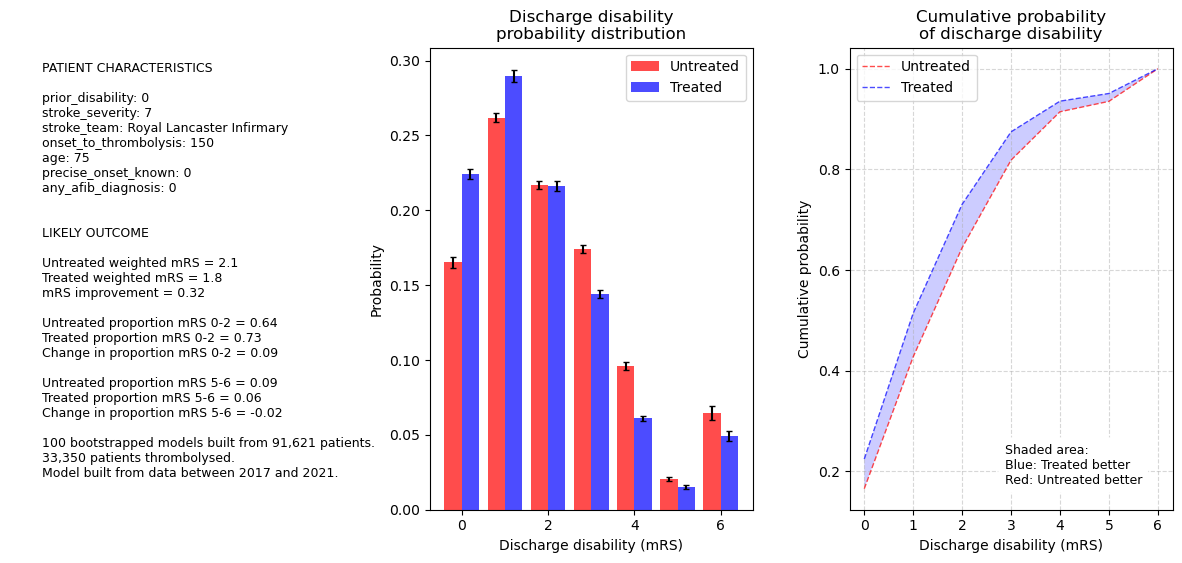

In [3]:
# For a 'typical/neutral' hospital, use "Royal Lancaster Infirmary"

patient = {
    'prior_disability': 0,
    'stroke_severity': 7,
    'stroke_team': "Royal Lancaster Infirmary",
    'onset_to_thrombolysis': 150,
    'age': 75,
    'precise_onset_known': 0,
    'any_afib_diagnosis': 0
    }

analyse_patient(patient)

## Proportion of patients that may be suitable for thrombolysis

In [4]:
# Load full data
full_data = pd.read_csv('./data/data_for_models.csv', low_memory=False)

# Create mask
mask_1 = ((full_data['infarction'] == 1) &
          (full_data['onset_to_arrival_time'] < 240) &
          (full_data['onset_known'] == 1) &
          (full_data['afib_anticoagulant'] == 0) &
          (full_data['stroke_severity'] >= 5))

print (f'Proportion patients suitable NIHSS 5+: {np.mean(mask_1):0.3f}')

# Create mask, but change NIHSS to 1+
mask_2 = ((full_data['infarction'] == 1) &
          (full_data['onset_to_arrival_time'] < 240) &
          (full_data['onset_known'] == 1) &
          (full_data['afib_anticoagulant'] == 0) &
          (full_data['stroke_severity'] >= 1))

print (f'Proportion patients suitable NIHSS 1+: {np.mean(mask_2):0.3f}')

Proportion patients suitable NIHSS 5+: 0.113
Proportion patients suitable NIHSS 1+: 0.188


What proportion of patients are NIHSS 1-4 and arrive within two hours of stroke onset.

In [5]:
# Create mask, but change NIHSS to 1+
mask_3 = ((full_data['infarction'] == 1) &
          (full_data['onset_to_arrival_time'] < 120) &
          (full_data['onset_known'] == 1) &
          (full_data['afib_anticoagulant'] == 0) &
          (full_data['stroke_severity'] > 0) &
          (full_data['stroke_severity'] < 5))

print (f'Proportion of patients who are NIHSS 1-4 and arrive within two hours of stroke onset: {np.mean(mask_3):0.3f}')

Proportion of patients who are NIHSS 1-4 and arrive within two hours of stroke onset: 0.040


Proportion of patients who are:
1) NIHSS 1-4 and arrive within two hours of stroke onset
*or*
2) NIHSS 5+ and arrive within four hours of stroke onset

In [6]:
total = np.mean(mask_1) + np.mean(mask_3)
print (f'Total number of patients suitable for thrombolysis: {total:.3f}')

Total number of patients suitable for thrombolysis: 0.152


Of stroke patients who are iscahemic stroke and arrive within 4 hours of stroke onset, what proportion are mild?

In [7]:
mask_1 = ((full_data['infarction'] == 1) & 
            (full_data['onset_to_arrival_time'] < 240))
          
mask_2 = ((full_data['infarction'] == 1) &
            (full_data['onset_to_arrival_time'] < 240) &
            (full_data['stroke_severity'] < 5))

proportion_mild = np.sum(mask_2) / np.sum(mask_1)

print (f'{proportion_mild:0.2f}')

0.44


Of mild ischaemic stroke patients, what proportion arrive in 2 hours?

In [8]:
# Of mild ischaemic stroke patients, what proportion arrive in 2 hours?
mask_1 = ((full_data['infarction'] == 1) &
          (full_data['stroke_severity'] < 5 ) &
          (full_data['onset_known'] == 1))

mask_2 = ((full_data['infarction'] == 1) &
            (full_data['stroke_severity'] < 5) &
            (full_data['onset_to_arrival_time'] < 120))

proportion_mild = np.sum(mask_2) / np.sum(mask_1)

print (f'{proportion_mild:0.2f}')


0.24


# To Do 

Convert to thresholds
Some fixed prototype patiente